## Part 2: Clinical Application

### Contents
This notebook as part 2 of Motion Compensated Pulse Rate Estimation project.

- [Code](#Code) is where the main cond with some parts of the **pulse rate algorithm** I've created and tested in Part 1.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) describes the clinical significance we observed from the **pulse rate algorithm** applied to this dataset. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code

In [11]:
import glob
import os

import numpy as np
import pandas as pd
import re

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
print('Installed Seaborn version is :', sns.__version__)
if int(sns.__version__.split('.')[1]) < 10:
    !pip install seaborn --upgrade
    import seaborn as sns
    print('Upgraded Seaborn version is :', sns.__version__)

Installed Seaborn version is : 0.11.0


#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [8]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [10]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
metadata = pd.read_csv(metadata_filename)
display(metadata.head())
display(metadata.info())
display(metadata.describe())

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 3 columns):
subject    1543 non-null object
age        1543 non-null object
sex        1543 non-null object
dtypes: object(3)
memory usage: 36.2+ KB


None

,subject,age,sex
count,1543,1543,1543
unique,1543,11,2
top,f124a,60-64,Male
freq,1,313,1266


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [12]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)
    
    # Find the subject ID from the filename.
    subject = re.split(r'/|\.', filename)[-2]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata.subject == subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata.subject == subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])
display(df.head())
display(df.info())
display(df.describe())

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
age_group    1537 non-null object
sex          1537 non-null object
rhr          1537 non-null float64
dtypes: float64(1), object(2)
memory usage: 36.1+ KB


None

,rhr
count,1537.000000
mean,63.547747
std,13.357361
min,1.558870
25%,54.468085
50%,62.439024
75%,71.111111
max,109.714286


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

In [13]:
labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')

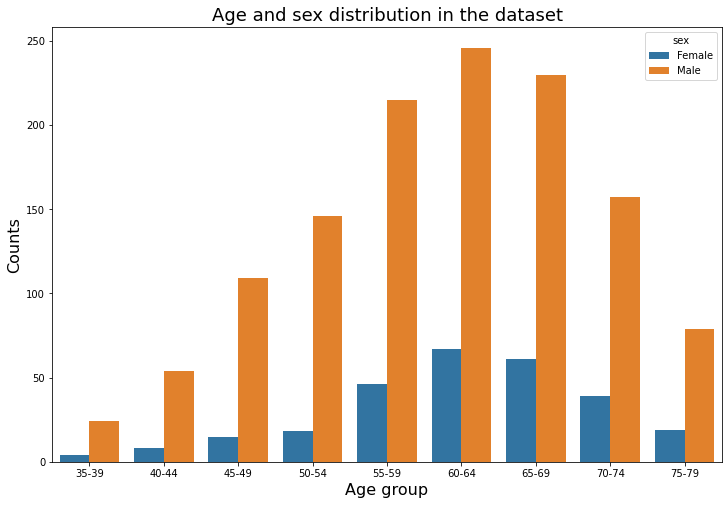

In [21]:
# age and sex distribution in the dataset
plt.figure(figsize=(12, 8))
sns.countplot(x='xaxis', hue='sex', data=df)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Age group', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Age and sex distribution in the dataset', fontsize=18)
plt.show()

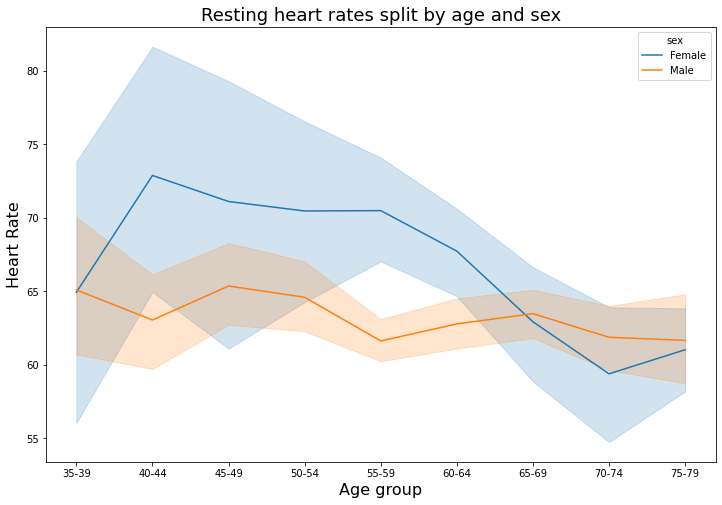

In [22]:
# resting heart rates for each age group
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
plt.xlabel('Age group', fontsize=16)
plt.ylabel('Heart Rate', fontsize=16)
_ = plt.xticks(np.arange(len(labels)), labels)
plt.title('Resting heart rates split by age and sex', fontsize=18)
plt.show()

### Clinical Conclusion

**Female:**
    * Female sample size is relatively small compare to the entire data set.
    * Females are mostly represented by age groups 55 to 74 years old. 
    * Heart rate is increased for females ages 40-60, then drops, which may be consistent with general population
    * High variance for age 35-60, which could be related to a small sample size in the dataset.

**Male:**
    * Males represents the majority in the data set.
    * Male samples are mostly represented by age groups 55 to 74 years old. 
    * Heart rate slightly decreasing over the age, with slight increase for age groups 45-55 years old, which is partially consistent with the general population trend.
    * The variance are quite low for age groups 45 to 75 years old, which is probably correlates with sample size for this age groups.  
    
**Female and Male heart rate comparison:**
    * Female sample size is relatively small compare to male, and different from the female/male ratio of the general population.
    * Age distribution shape for both genders looks similar.
    * Female's heart rate is higher in the age groups up to 70 year old, where the female heart rate crossing males heart rate curve and goes further down. 
    * Heart rate variance in female is much higher than in males, which consistent with the sample size. The curves are overlapped most of the time, except for the group of 55-59 years old, where the variance is small due to the high sample size and big gap between female and male’s heart rate means.

**What are some possible reasons for what we see in our data?:**
    * Different sample size for different genders.
    * Different sample size for different age groups.
    * The dataset represents population who have had a myocardial infarction within the past two years, which can explain age and gender distributions, and the high variance of the heart rate.

**What else can we do or go and find to figure out what is really happening? How would that improve the results?:**
    * The CAST study information can be found [here](https://physionet.org/content/crisdb/1.0.0/). The very selective group of population with possible high difference in heart rate were involved in this study.
    * The heart rate depends on the disease stage and treatment of the subjects recruited for this study.
    * More data needed to have gender and age groups more representative of the general population.

**Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?**
    * We can see the trend in the heart rate of increasing and then decreasing of heart rate in old adults, especially for females in this data set. 
    * We cannot validate this trend due to small sample size and the age and gender distributions are not representative for the general population due to the preexisting myocardial infarction conditions.